### Reddit Scarpping 

In [ ]:
import praw
import csv
import os
import time
from datetime import datetime  # Import datetime for timestamp conversion

# Initialize Reddit client
reddit = praw.Reddit(
    client_id='CLIENT_ID',
    client_secret='CLIENT_SECRETS',
    user_agent='python:personalproject:1.0 (by /u/Ratkovichh)'
)

# Prompt user for input keyword and number of posts
keyword = input("Enter the keyword to search for: ")
num_posts = int(input("Enter the number of posts to scrape: "))

# Initialize a list to store the scraped data
scraped_data = []

# Define the CSV file name
csv_filename = 'reddit_scraped_data.csv'

# Check if the file exists to determine the starting post number
if os.path.isfile(csv_filename):
    with open(csv_filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file)
        # Skip the header
        next(reader)
        # Read the last line
        last_line = None
        for last_line in reader:
            pass
        if last_line:
            # Continue numbering from the last post number
            post_number = int(last_line[0]) + 1
        else:
            post_number = 1
else:
    post_number = 1

# Initialize posts fetched count
posts_fetched = 0

# Search Reddit for the keyword in all subreddits
while posts_fetched < num_posts:
    for submission in reddit.subreddit('all').search(keyword, limit=100):  # Fetch in chunks of 100
        if posts_fetched >= num_posts:
            break
        
        # Extract the necessary data
        title = submission.title
        body = submission.selftext
        score = submission.score
        num_comments = submission.num_comments
        # Convert the timestamp to a readable format
        created_time = datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S')
        
        # Append the data to the list
        scraped_data.append([post_number, title, body, score, num_comments, created_time])
        
        # Increment post number and posts fetched count
        post_number += 1
        posts_fetched += 1
    
    # Introduce a delay to avoid hitting Reddit API rate limits
    time.sleep(2)  # Adjust sleep time if necessary

# Check if the file exists to determine whether to write headers
file_exists = os.path.isfile(csv_filename)

# Write the data to a CSV file (appending)
with open(csv_filename, mode='a', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    
    # Write the header row only if the file didn't exist
    if not file_exists:
        writer.writerow(['Post Number', 'Title', 'Body', 'Score', 'Number of Comments', 'Timestamp'])
    
    # Write the scraped data
    writer.writerows(scraped_data)

print(f"{posts_fetched} posts have been scraped successfully! The results have been appended to '{csv_filename}'.")

### Importing the csv post Scrapping

In [97]:
import pandas as pd
data=pd.read_csv('reddit_scraped_data.csv')
data.head(10)

,Post Number,Title,Body,Score,Number of Comments,Timestamp
0,1,John Fetterman was open about his depression. ...,NaN,4957,428,2024-05-18 16:40:11
1,2,Night Owls Could Be Upping Their Mental Health...,NaN,4618,514,2024-05-31 11:46:49
2,3,Coaxed Into Mental Health Problems,NaN,2772,222,2024-08-16 10:51:27
3,4,Millennial Wellness Check: How’s Ya’ll’s Menta...,Personally I’m drowning in depression and rewa...,3167,731,2024-07-22 20:52:52
4,5,Many ICU staff have experienced mental health ...,NaN,18965,541,2021-07-21 16:36:06
5,6,Songs about depression/poor mental health,"I listened to a song called ""Getting by"" by Ga...",162,266,2024-02-08 13:55:28
6,7,Kendra Wilkinson Breaks Silence on Her Crippli...,NaN,1924,148,2024-01-16 23:21:52
7,8,Tattoo regret and mental health,"Hello, this is gonna be a pretty long text but...",2716,853,2023-09-03 15:07:04
8,9,Rob Mental Health,This was a comment I posted on the call her da...,1059,195,2024-07-24 07:46:54
9,10,Sad depressing songs about mental health,"I’m looking for slow, sad, depressing songs ab...",69,182,2024-05-31 21:53:31


### Checking for null values

In [98]:
data.isnull().sum()

Post Number              0
Title                    0
Body                  9850
Score                    0
Number of Comments       0
Timestamp                0
dtype: int64

### Dropping null values, changing indexes and dropping irrelevent columns

In [99]:
data.dropna(inplace=True)
data.index=pd.to_datetime(data['Timestamp'])
data=data.drop(columns=['Post Number','Timestamp'])
data.head()

,Title,Body,Score,Number of Comments
Timestamp,,,,
2024-07-22 20:52:52,Millennial Wellness Check: How’s Ya’ll’s Menta...,Personally I’m drowning in depression and rewa...,3167,731
2024-02-08 13:55:28,Songs about depression/poor mental health,"I listened to a song called ""Getting by"" by Ga...",162,266
2023-09-03 15:07:04,Tattoo regret and mental health,"Hello, this is gonna be a pretty long text but...",2716,853
2024-07-24 07:46:54,Rob Mental Health,This was a comment I posted on the call her da...,1059,195
2024-05-31 21:53:31,Sad depressing songs about mental health,"I’m looking for slow, sad, depressing songs ab...",69,182


In [100]:
data.shape

(24150, 4)

### Preprocssing Body of the posts

In [32]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+',' ',text) #remove URLs
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

data['Cleaned_Body'] = data['Body'].apply(clean_text)


In [33]:
data['Cleaned_Body']

Timestamp
2024-07-22 20:52:52    personally drowning depression rewatching walk...
2024-02-08 13:55:28    listened song called getting gabriel paris rea...
2023-09-03 15:07:04    hello gonna pretty long text really desperate ...
2024-07-24 07:46:54    comment posted call daddy podcast recap rob ha...
2024-05-31 21:53:31    looking slow sad depressing song mental health...
                                             ...                        
2019-07-01 10:41:51    rise social medium signifies global population...
2024-02-05 14:58:46    yesterday 18m bought xbox series x want play f...
2020-10-20 22:56:36    dear member r basketball part research team un...
2024-04-05 09:44:39    final year psychology degree need participant ...
2024-05-30 16:41:17    often scroll past post discussing difficult ma...
Name: Cleaned_Body, Length: 24150, dtype: object

### Getting the most frequent words

Text(0, 0.5, 'Count')

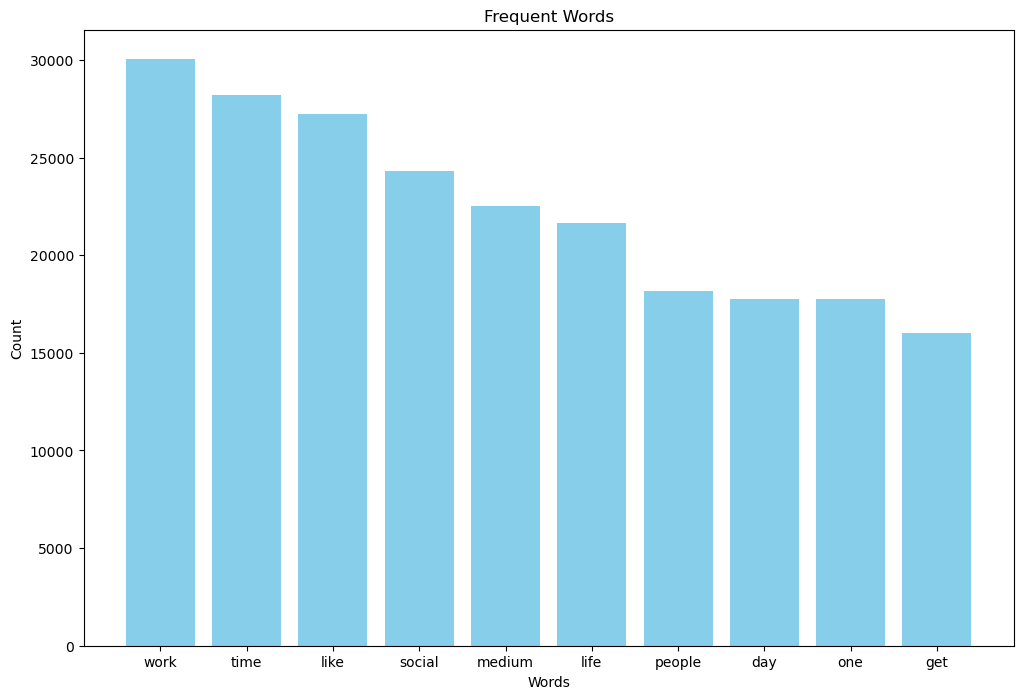

In [94]:
from collections import Counter

word_count = Counter(" ".join(data['Cleaned_Body']).split())
common_words = word_count.most_common(12)[2:]
words, counts = zip(*common_words)
plt.figure(figsize=(12, 8))
plt.bar(words, counts, color='skyblue')
plt.title('Frequent Words')
plt.xlabel('Words')
plt.ylabel('Count')

### Getting the sentiment of each post

Text(0.5, 1.0, 'Sentiment Analysis')

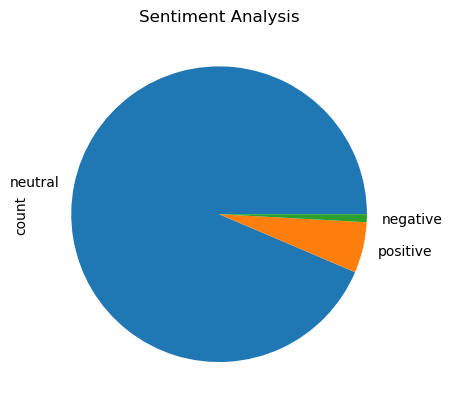

In [95]:
from textblob import TextBlob
data['Sentiment'] = data['Cleaned_Body'].apply(lambda text: TextBlob(text).sentiment.polarity)
def classify_sentiment(polarity):
    if polarity > 0.25:
        return 'positive'
    elif polarity < -0.25:
        return 'negative'
    else:
        return 'neutral'
data['Sentiment']=data['Sentiment'].apply(classify_sentiment)
sentiment_counts = data['Sentiment'].value_counts().plot(kind='pie')
plt.title('Sentiment Analysis')

### Word Cloud

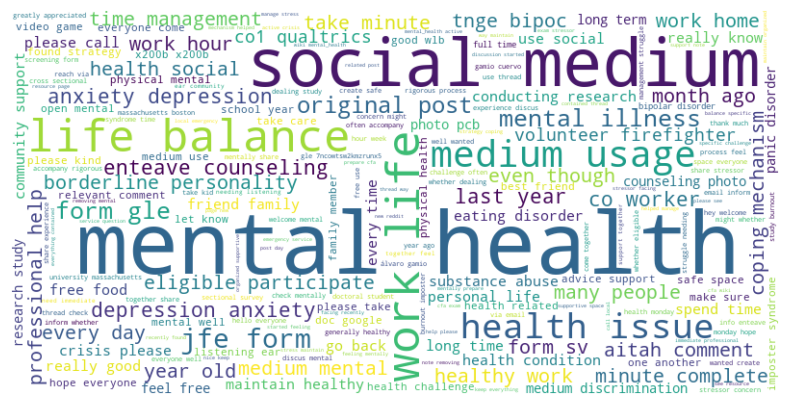

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Word cloud for cleaned text
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(data['Cleaned_Body']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Societal issues dictionary with keywords

In [38]:
societal_issues = {
    'Unemployment': [
        'job loss', 'unemployment', 'layoffs', 'hiring freeze', 'jobless',
        'fired', 'terminated', 'out of work', 'employment crisis', 'career setbacks'
    ],
    'Substance Abuse': [
        'drugs', 'alcohol', 'addiction', 'substance abuse', 'narcotics', 
        'overdose', 'rehabilitation', 'alcoholism', 'drug abuse', 'substance dependency'
    ],
    'Social Isolation': [
        'loneliness', 'isolation', 'social withdrawal', 'solitude', 'alienation', 
        'social disconnect', 'feeling alone', 'lack of social interaction', 'social distancing'
    ],
    'Poverty': [
        'poverty', 'low income', 'financial hardship', 'economic struggle', 'impoverished', 
        'poor', 'debt', 'bankruptcy', 'income inequality', 'living in poverty'
    ],
    'Healthcare Access': [
        'healthcare', 'medical care', 'insurance', 'treatment access', 'health services', 
        'medical treatment', 'doctor visit', 'hospital care', 'medical bills', 'uninsured'
    ],
    'Education': [
        'education', 'schooling', 'college', 'learning', 'tuition', 'student debt', 
        'higher education', 'dropout', 'educational system', 'academic struggles'
    ],
    'Crime': [
        'crime', 'violence', 'theft', 'assault', 'murder', 'burglary', 
        'criminal activity', 'robbery', 'gangs', 'violent crime'
    ],
    'Housing': [
        'housing', 'homelessness', 'shelter', 'rent', 'eviction', 
        'foreclosure', 'affordable housing', 'housing crisis', 'living conditions', 'residential issues'
    ],
    'Discrimination': [
        'discrimination', 'racism', 'sexism', 'bias', 'prejudice', 
        'hate crime', 'inequality', 'gender bias', 'racial injustice', 'discriminatory practices'
    ],
    'Political Instability': [
        'politics', 'instability', 'government', 'corruption', 'civil unrest', 
        'political turmoil', 'protest', 'election fraud', 'political crisis', 'authoritarianism'
    ],
    'Economic Inequality': [
        'inequality', 'wealth gap', 'economic disparity', 'rich vs poor', 
        'income inequality', 'class divide', 'social inequality', 'financial inequality', 'economic injustice'
    ],
    'Family Dynamics': [
        'family issues', 'domestic violence', 'parenting', 'childcare', 
        'divorce', 'marital problems', 'family conflict', 'family relationships', 'child abuse', 'parental challenges'
    ],
    'Work-Life Balance': [
        'work-life balance', 'burnout', 'stress at work', 'overwork', 'work pressure', 
        'job stress', 'work stress', 'work-related stress', 'employee burnout', 'work overload'
    ],
    'Social Media Usage': [
        'social media', 'online', 'internet addiction', 'digital', 'social networks', 
        'cyberbullying', 'screen time', 'social media addiction', 'online presence', 'digital communication'
    ],
    'Environmental Concerns': [
        'environment', 'climate change', 'pollution', 'sustainability', 'global warming', 
        'environmental degradation', 'carbon footprint', 'eco-friendly', 'renewable energy', 'environmental protection'
    ],
}


### Classifying posts 

In [39]:
def classify_issue_simple(body_text):
    for issue, keywords in societal_issues.items():
        for keyword in keywords:
            if keyword in body_text.lower():
                return issue
    return 'Personal Issues'
data['Societal_Issues'] = data['Cleaned_Body'].apply(classify_issue_simple)
data.head()

,Title,Body,Score,Number of Comments,Cleaned_Body,Sentiment,Societal_Issues
Timestamp,,,,,,,
2024-07-22 20:52:52,Millennial Wellness Check: How’s Ya’ll’s Menta...,Personally I’m drowning in depression and rewa...,3167,731,personally drowning depression rewatching walk...,-0.025000,Personal Issues
2024-02-08 13:55:28,Songs about depression/poor mental health,"I listened to a song called ""Getting by"" by Ga...",162,266,listened song called getting gabriel paris rea...,0.114286,Personal Issues
2023-09-03 15:07:04,Tattoo regret and mental health,"Hello, this is gonna be a pretty long text but...",2716,853,hello gonna pretty long text really desperate ...,-0.143919,Personal Issues
2024-07-24 07:46:54,Rob Mental Health,This was a comment I posted on the call her da...,1059,195,comment posted call daddy podcast recap rob ha...,-0.020725,Poverty
2024-05-31 21:53:31,Sad depressing songs about mental health,"I’m looking for slow, sad, depressing songs ab...",69,182,looking slow sad depressing song mental health...,-0.225000,Personal Issues


### Frequency of each each societal issue

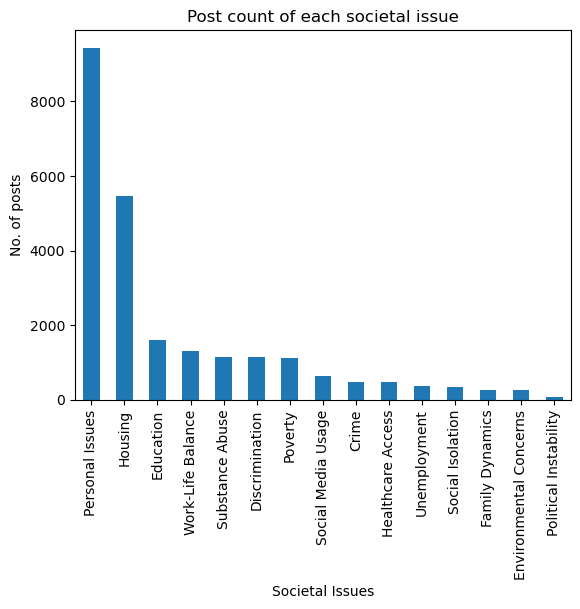

In [93]:
data['Societal_Issues'].value_counts().plot(kind='bar')
plt.xlabel('Societal Issues')
plt.ylabel('No. of posts')
plt.title('Post count of each societal issue')
plt.show()

### Plotting the frequency on time series

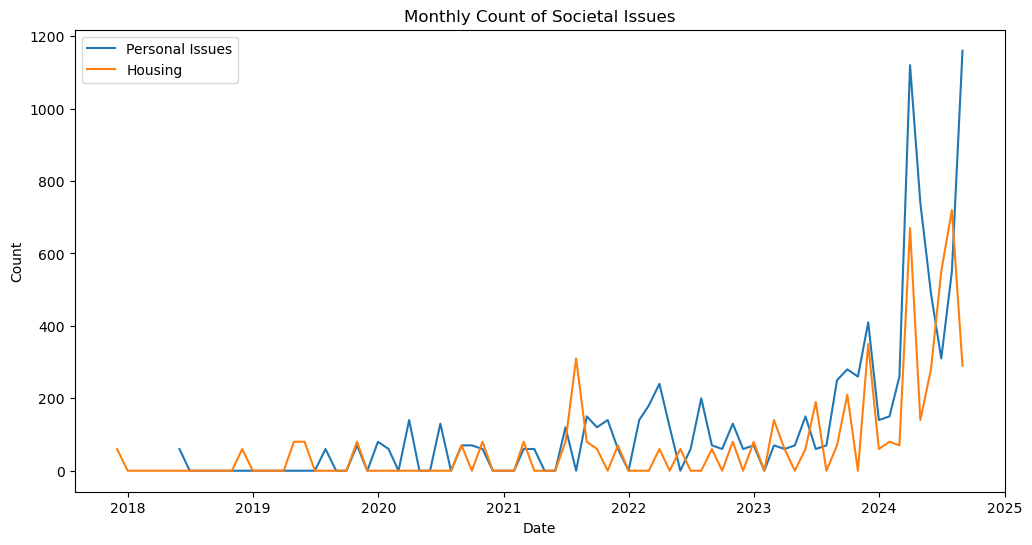

In [90]:
import matplotlib.pyplot as plt
li = ['Personal Issues', 'Housing']
lines = []
plt.figure(figsize=(12, 6))
for i in li:
    df_poverty = data[data['Societal_Issues'] == i]
    df_poverty_monthly = df_poverty.resample('M').size()
    line, = plt.plot(df_poverty_monthly.index, df_poverty_monthly, linestyle='-', label=i)
    lines.append(line)  
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Monthly Count of Societal Issues')
plt.legend([line for line in lines], li)
plt.show()

### Plotting scores based each societal issue

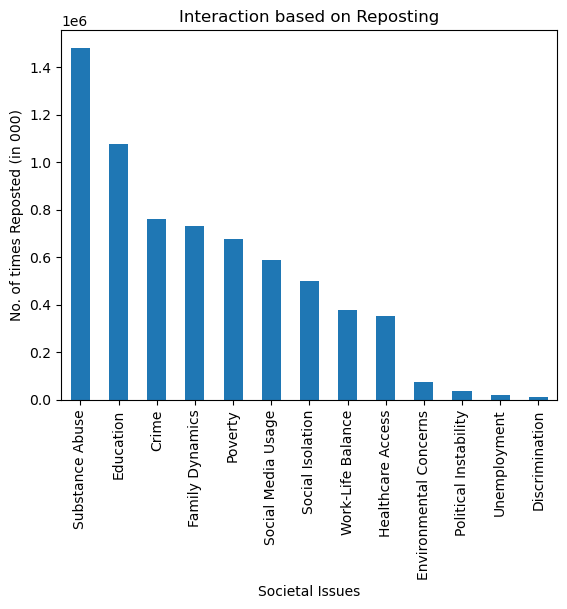

In [91]:
data.groupby('Societal_Issues').sum()['Score'].sort_values(ascending=False)[2:].plot(kind='bar')
plt.xlabel('Societal Issues')
plt.ylabel('No. of times Reposted (in 000)')
plt.title('Interaction based on Reposting')
plt.show()

### plotting based on engagement of each domain

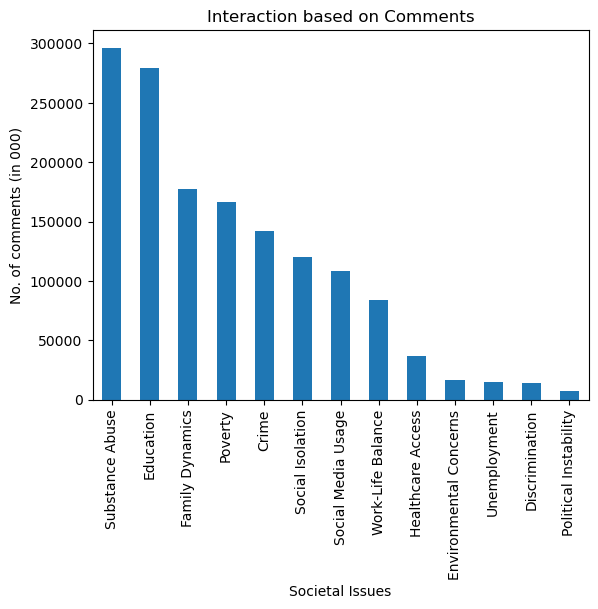

In [92]:
data.groupby('Societal_Issues').sum()['Number of Comments'].sort_values(ascending=False)[2:].plot(kind='bar')
plt.xlabel('Societal Issues')
plt.ylabel('No. of comments (in 000)')
plt.title('Interaction based on Comments')
plt.show()

## End